# Приближенное решение смешанной краевой задачи для неоднородного волнового уравнения

## Вариант 20

> <span style="font-style:normal; font-size:12pt;"> 
        <ol> 
            <li>Найти численное решение смешанной краевой задачи для неоднородного волнового уравнения при x на отрезке [0,1].
                Для расчета решения использовать схему "крест" с шагом h = 0.05 по переменной x. Предусмотреть возможность
                произвольного задания шага по переменной t и времени окончания расчета (по умолчанию
                τ = 0.05 и T = 1, соответственно). </li>
            <li>Для получения решения использовать начальные и граничные условия первого и
                второго порядка точности.</li>
        </ol> 
    <p>  Для сравнения приведено точное решение u0(x,t). </p>
    
$$
\begin{cases}
u_{tt} = \frac{1}{2}u_{xx} - \frac{3}{2} + \frac{xe^{-t}}{2(4 - x^2)^{3/2}} + e^{-t} \arccos{\frac{x}{2}}, \\
u(x,0)   = \frac{3}{2} x^2 + \arccos{\frac{x}{2}},              \\ 
u_t(x,0) = -\arccos{\frac{x}{2}},                      \\ 
2u(0,t) + u_x(0,t) = (\pi - \frac{1}{2}) e^{-t}, \\
u(1,t)   = \frac{3}{2} + \frac{\pi}{3}e^{-t},    \\ 
\end{cases}
$$

$$
\begin{equation}
u_{0}(x,t)  = \frac{3}{2}x^{2} + e^{-t} \arccos{\frac{x}{2}}
\end{equation}
$$

In [1]:
%matplotlib widget

import numpy  as np
import pandas as pd
from matplotlib           import pyplot as plt
from matplotlib.widgets   import Slider, Button
from mpl_toolkits.mplot3d import axes3d
from matplotlib           import cm

In [2]:
def solve_eq(x_plot, t_plot, a, f, 
             phi_1, phi_1xx, phi_2, 
             alpha_1, beta_1, gamma_1, alpha_2, beta_2, gamma_2, precision=1):
    u_plot = []
    h = x_plot[1] - x_plot[0]
    t = t_plot[1] - t_plot[0]
    
    # Первые два слоя по времени из начальных условий
    layer_0 = [phi_1(xk) for xk in x_plot]
    
    if precision == 1:
        layer_1 = [phi_2(xk) * t + uk_0 for xk, uk_0 in zip(x_plot, layer_0)]    
    if precision == 2:
        layer_1 = [uk_0 + phi_2(xk) * t + (t**2 / 2) * (a**2 * phi_1xx(xk) + f(xk, 0)) for xk, uk_0 in zip(x_plot, layer_0)]

    u_plot.append(layer_0)
    u_plot.append(layer_1)
        
        
    # Считаем следующие слои
    # Определяем значения на границе из граничных условий

    layer_i = layer_1
    layer_j = layer_0

    for n in range(1, len(t_plot) - 1):
        layer = []                       # вычисляемый слой

        for k in range(1, len(x_plot) - 1):
            u_nk = ((a**2 * t**2 / h**2) * (layer_i[k + 1] - 2 * layer_i[k] + layer_i[k - 1]) + 
                    t**2 * f(x_plot[k], t_plot[n]) + 2 * layer_i[k] - layer_j[k])
            layer.append(u_nk)
            
            
        if precision == 1:
            u_n0 = ((gamma_1(t_plot[n + 1]) - alpha_1(t_plot[n + 1]) * layer[0] / h) / 
                    (beta_1(t_plot[n + 1])  - alpha_1(t_plot[n + 1]) / h))
            u_nN = ((gamma_2(t_plot[n + 1]) + alpha_2(t_plot[n + 1]) * layer[-1] / h) / 
                    (alpha_2(t_plot[n + 1]) / h + beta_2(t_plot[n + 1])))

        if precision == 2:
            u_n0 = ((2 * h * gamma_1(t_plot[n + 1]) - 4 * alpha_1(t_plot[n + 1]) * layer[0]  + alpha_1(t_plot[n + 1]) * layer[1]) / 
                    (2 * h * beta_1(t_plot[n + 1])  - 3 * alpha_1(t_plot[n + 1])))
            u_nN = ((2 * h * gamma_2(t_plot[n + 1]) + 4 * alpha_2(t_plot[n + 1]) * layer[-1] - alpha_2(t_plot[n + 1]) * layer[-2]) / 
                    (3 * alpha_2(t_plot[n + 1]) + 2 * h * beta_2(t_plot[n + 1])))

            
        layer.insert(0, u_n0)
        layer.append(u_nN)

        u_plot.append(layer)

        layer_j = layer_i
        layer_i = layer

    return u_plot

In [3]:
def error_fig(X, Y, errors, precision=1):
    fig = plt.figure(figsize=(8, 8))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, errors, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('x', fontsize=10)        
    ax.set_ylabel('t', fontsize=10)
    ax.set_zlabel('error', fontsize=10)

    if precision == 1:
        plt.title('Ошибка первого порядка', fontsize=10)
    if precision == 2:
        plt.title('Ошибка второго порядка', fontsize=10)
    
    plt.show()
    
    print("h = ", X[0][1] - X[0][0], "t = ", Y[1][0] - Y[0][0])

In [4]:
def decision_fig(X, Y, Z0, Z, precision=1):
    fig = plt.figure(figsize=(8, 8))
    ax  = fig.add_subplot(111, projection='3d')

    ax.plot_wireframe(X, Y, Z0,  rstride=10, cstride=10, label='analytical solution')
    
    if precision == 1:
        ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color='orange', label='precision_1')
    if precision == 2:
        ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color='orange', label='precision_2')
        
    ax.set_xlabel('x', fontsize=10)        
    ax.set_ylabel('t', fontsize=10)
    ax.set_zlabel('u', fontsize=10)

    plt.title('Численное решение', fontsize=10)
    plt.legend(fontsize=8)

    plt.show()
    
    print("h = ", X[0][1] - X[0][0], "t = ", Y[1][0] - Y[0][0])

## Постановка задачи

In [5]:
# неоднородность
def f(x, t):
    return (-3 / 2) + (1 / 2) * x * np.exp(-t) / np.power(4 - x**2, 3 / 2) + np.exp(-t) * np.arccos(x / 2) 

# начальные условия
def phi_1(x):
    return (3 / 2) * x**2 + np.arccos(x / 2)

def phi_1xx(x):
    return 3 - (1 / 8) * x / np.power(1 - (x / 2)**2, 3 / 2)

def phi_2(x):
    return (-1) * np.arccos(x / 2)


# граничные условия
def gamma_1(t):
    return (np.pi - 1 / 2) * np.exp(-t)

def gamma_2(t):
    return  (3 / 2) + np.pi * np.exp(-t) / 3


# Параметры
def alpha_1(t):
    return 1

def beta_1(t):
    return 2

def alpha_2(t):
    return 0

def beta_2(t):
    return 1

# точное решение для анализа
def u(x, t):
    return (3 / 2) * x**2 + np.exp(-t) * np.arccos(x / 2)


# Область значений и шаг по x
left  = 0
right = 1
h     = 0.05 

# Область значений и шаг по t
t0 = 0
T  = 1
t  =  0.05

# коэффициент волнового уравнения
a = np.sqrt(1 / 2)

In [6]:
x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
t_plot = np.linspace(t0,   T,     round((T - t0) / t) + 1)             # временная сетка (слои)

In [7]:
print(x_plot[1] - x_plot[0])
print(t_plot[1] - t_plot[0])

0.05
0.05


## Численное решение

### 1. Начальные и граничные условия первого порядка точности

In [8]:
u_plot1 = solve_eq(x_plot, t_plot, a, f, 
                   phi_1, phi_1xx ,phi_2, 
                   alpha_1, beta_1, gamma_1, alpha_2, beta_2, gamma_2, precision=1)

In [9]:
X, Y = np.meshgrid(x_plot, t_plot)
Z0   = u(X, Y)
Z    = np.asarray(u_plot1)

#### График решения

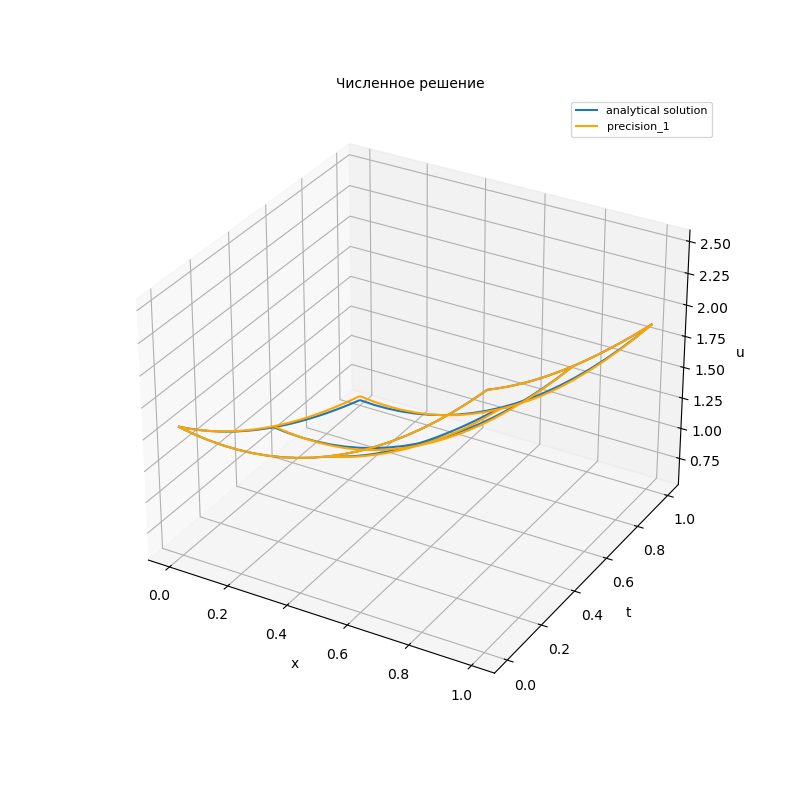

h =  0.05 t =  0.05


In [10]:
decision_fig(X, Y, Z0, Z, precision=1)

#### Погрешность

In [11]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)
    
errors = np.array(errors)

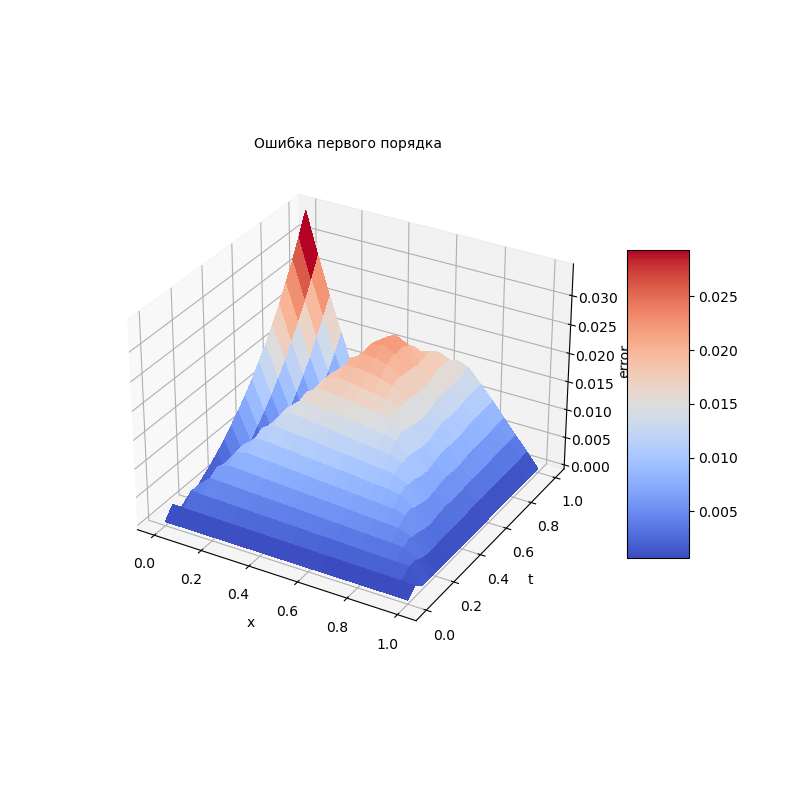

h =  0.05 t =  0.05


In [12]:
error_fig(X, Y, errors, precision=1)

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [13]:
np.max(errors)

0.034672839403465106

### 2. Начальные и граничные условия второго порядка точности

In [14]:
u_plot2 = solve_eq(x_plot, t_plot, a, f, 
                   phi_1, phi_1xx ,phi_2, 
                   alpha_1, beta_1, gamma_1, alpha_2, beta_2, gamma_2, precision=2)

In [15]:
X, Y = np.meshgrid(x_plot, t_plot)
Z0   = u(X, Y)
Z    = np.asarray(u_plot2)

#### График решения

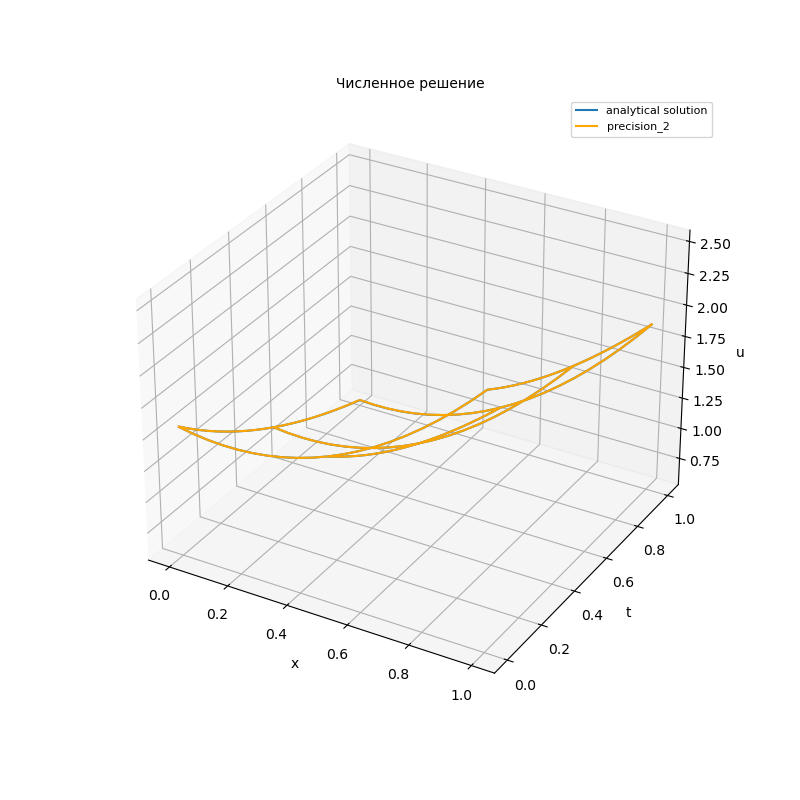

h =  0.05 t =  0.05


In [16]:
decision_fig(X, Y, Z0, Z, precision=2)

#### Погрешность

In [17]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)
    
errors = np.array(errors)

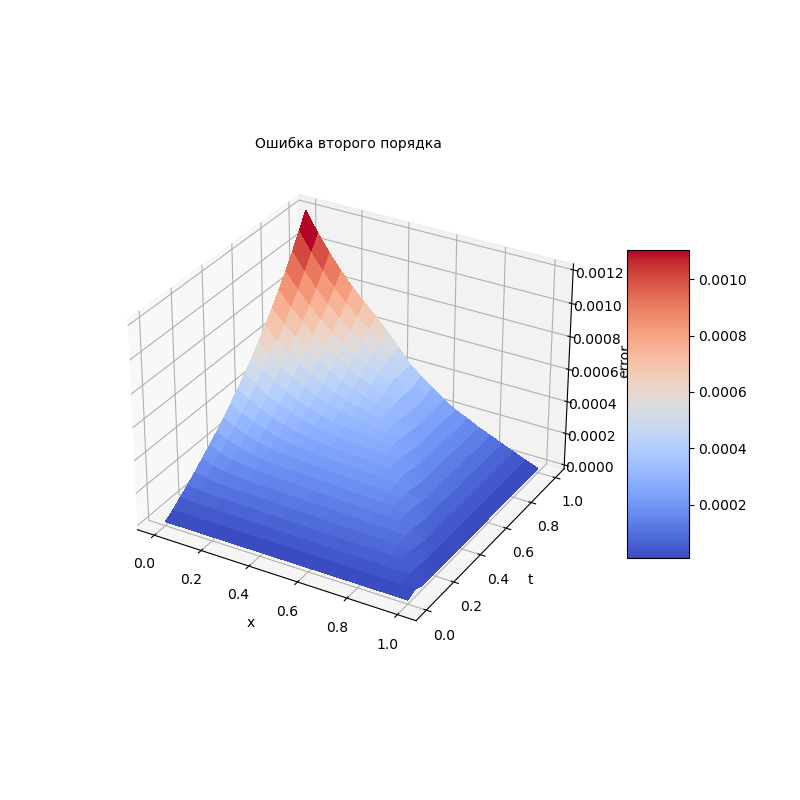

h =  0.05 t =  0.05


In [18]:
error_fig(X, Y, errors, precision=2)

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [19]:
np.max(errors)

0.0012095863527586959

### Условие Куранта

> <span style="font-style:normal; font-size:12pt;"> 
    <p> Ниже проверяется, как ведет себя максимальная ошибка в зависимости от вводимого значения числа точек. </p>

In [20]:
def max_error_problem(n):

    h = (right - left) / n
    t = 0.9 * h / a
        
    x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
    t_plot = np.linspace(t0,   T,     round((T - t0) / t) + 1)             # временная сетка (слои)
    
    print("h =", h, "  t =", t)
    print("x1 - x0 =", x_plot[1] - x_plot[0],  "\t\t t1 - t0 =", t_plot[1] - t_plot[0])
    
    
    X, Y = np.meshgrid(x_plot, t_plot)
    Z0   = u(X, Y)
    
    u_plot2 = solve_eq(x_plot, t_plot, a, f, 
                       phi_1, phi_1xx ,phi_2, 
                       alpha_1, beta_1, gamma_1, alpha_2, beta_2, gamma_2, precision=2)
    Z   = np.asarray(u_plot2)
    
    
    errors = []

    for i in range(len(Z0)):
        errors_i = [abs(z0 - z) for z0, z in zip(Z0[i], Z[i])]
        errors.append(errors_i)

    errors = np.array(errors)
    
    return n, np.max(errors)

#### Вычисления

In [21]:
max_errors = []
n_plot     = []

n = 10

while n < 2000:
    
    # Через условие Куранта определим шаг временной сетки

    #   Условие Куранта:
    #   a * t / h < 1  
    
    _, max_error = max_error_problem(n)
    
    print("max_error = ", max_error, end="\n\n")
    
    n_plot.append(n)
    max_errors.append(max_error)  
    
    n *= 2

h = 0.1   t = 0.12727922061357855
x1 - x0 = 0.1 		 t1 - t0 = 0.125
max_error =  0.007198001848639057

h = 0.05   t = 0.06363961030678927
x1 - x0 = 0.05 		 t1 - t0 = 0.0625
max_error =  0.0018270045404087387

h = 0.025   t = 0.03181980515339464
x1 - x0 = 0.025 		 t1 - t0 = 0.03225806451612903
max_error =  0.0004885147908508802

h = 0.0125   t = 0.01590990257669732
x1 - x0 = 0.0125 		 t1 - t0 = 0.015873015873015872
max_error =  0.00011893707409149634

h = 0.00625   t = 0.00795495128834866
x1 - x0 = 0.00625 		 t1 - t0 = 0.007936507936507936
max_error =  2.9789227551924036e-05

h = 0.003125   t = 0.00397747564417433
x1 - x0 = 0.003125 		 t1 - t0 = 0.00398406374501992
max_error =  7.51030138623765e-06

h = 0.0015625   t = 0.001988737822087165
x1 - x0 = 0.0015625 		 t1 - t0 = 0.0019880715705765406
max_error =  1.871399623265546e-06

h = 0.00078125   t = 0.0009943689110435824
x1 - x0 = 0.00078125 		 t1 - t0 = 0.0009940357852882703
max_error =  4.6795725849868575e-07



#### График зависимости

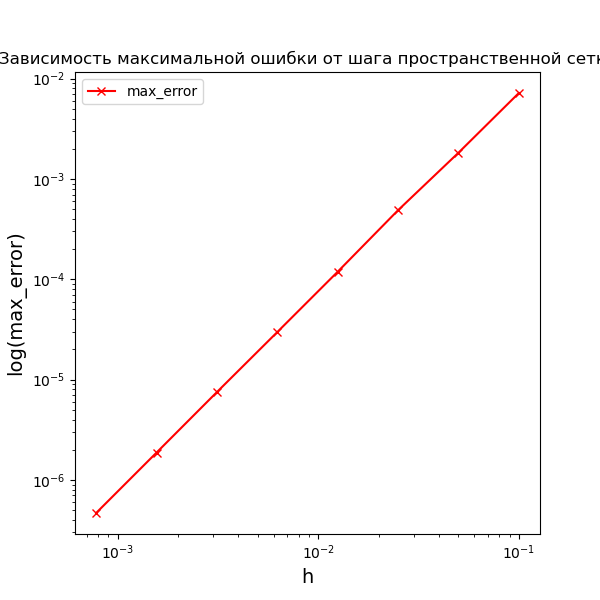

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Зависимость максимальной ошибки от шага пространственной сетки")

props = dict(boxstyle='square', facecolor='tomato', alpha=0.5)

ax.loglog(1/np.array(n_plot), max_errors, color="red", marker='x', label='max_error')
#plt.axvline(x=100, color="green", linewidth=0.5)
plt.text(102.5,  2 * 10**(-4), "h = {0:.2f}, \n t ~ {0:.2}".format(0.01, 0.012727922061357855), fontsize = 9, bbox=props)

ax.set_xlabel("h", fontsize=14)        
ax.set_ylabel("log(max_error)", fontsize=14)

ax.legend()

plt.show()

## Задача УМФ

<span style="font-style:italic; font-size:14pt;"> 
    <p>
    Струна (0 < x < L) длины L = 1. Левый свободный конец x=0 движется по закону 0.5sin(0.9t), на правый свободный конец x=L действует сила sin(0.4t). В начальный момент времени струна отклонена в точке x=L/2 на величину 3 и неподвижна. В момент времени t=0 струну отпускают.
    </p>




#### Постановка задачи

In [23]:
# неоднородность
def f(x, t):
    return 0

# начальные условия
def phi_1(x):
    if 0 <= x < (1 / 2):
        return 6 * x
    if (1 / 2) <= x <= 1:
        return 3 * (1 - x) / (1 - (1 / 2))

def phi_1xx(x):
    return 0

def phi_2(x):
    return 0


# граничные условия
def gamma_1(t):
    return 0.5 * np.sin(0.9 * t)

def gamma_2(t):
    return np.sin(0.4 * t) / 2


# Параметры
def alpha_1(t):
    return 0

def beta_1(t):
    return 1

def alpha_2(t):
    return 1

def beta_2(t):
    return 0

    
# Область значений и шаг по x
left  = 0
right = 1
h     = 0.005 

# Область значений и шаг по t
t0 = 0
T  = 1
t  =  0.005


# коэффициент волнового уравнения
a = 1.01 * h / t

#### Численное решение

In [24]:
x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
t_plot = np.linspace(t0,   T,     round((T - t0) / t) + 1)             # временная сетка (слои)

In [25]:
u_plot = solve_eq(x_plot, t_plot, a, f, 
                   phi_1, phi_1xx ,phi_2, 
                   alpha_1, beta_1, gamma_1, alpha_2, beta_2, gamma_2, precision=2)

In [26]:
X, Y = np.meshgrid(x_plot, t_plot)
Z    = np.asarray(u_plot)

#### Временная зависимость

In [27]:
def update(val):
    ydata  = u_plot[int(np.where(t_plot == val)[0])]
    line.set_ydata(ydata)
    fig.canvas.draw_idle()

def reset(event):
    time_slider.reset()

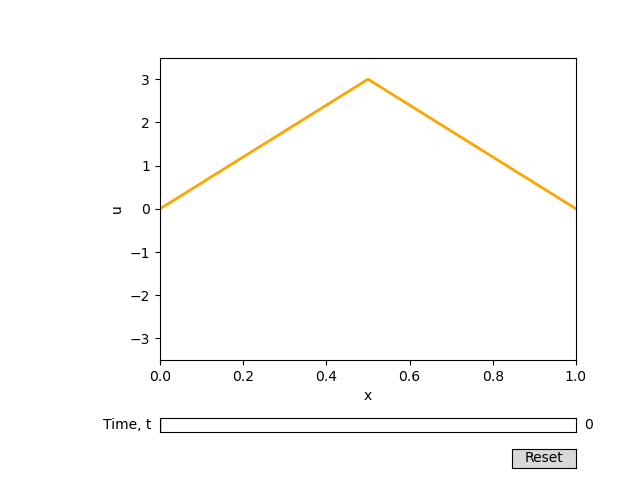

In [28]:
fig, ax = plt.subplots()
line,   = plt.plot(x_plot, u_plot[0], lw = 2, color = 'orange')
plt.xlim(0, 1)
plt.ylim(-3.5, 3.5)

ax.set_xlabel('x')
ax.set_ylabel('u')


plt.subplots_adjust(left = 0.25, bottom = 0.25)

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax      = ax_time,
    label   = 'Time, t',
    valmin  = t0,
    valmax  = T,
    valinit = 0,
    valstep = t,
    color   = 'orange'
)


time_slider.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button  = Button(resetax, 'Reset', hovercolor='0.975')

button.on_clicked(reset)


plt.show()